### Loadng the Data

In [49]:
import numpy as np
import matplotlib as mpl
from scipy.integrate import odeint
import pandas as pd
import pylab as p
import os
import csv

""" WL is the word-length """
WL = 5   

os.chdir('C:/Users/Miles/Documents/Brown/Ogbunu Lab/Evo Word') # sets the cwd to preferred directory 

file_name = '%s_Letter_OneGrams_1900_2000.csv'%WL   # for 4 letter words; the data was ordered from most popular words to least

""" defines a list called 'data' which holds the ngram scores for various years """
with open(file_name, 'r') as f:        
    reader = csv.reader(f)
    data = list(reader)                                        
    
for i in range(1,len(data)):
    data[i][1:] = map(int,data[i][1:])         # the above makes all elements strings, so this turns word counts to ints
    
ngram_words = []  
for i in range(1,len(data)):
    ngram_words.append(data[i][0])             # words from google's ngram
    
    
""" this identifies the most popular words, using our 97% cutoff criterion """

cutoff = [201,1501,5001][WL-3]
pop_words = [data[i][0] for i in range(1,cutoff)]   # this houses the popular words
      

### Word-pair Constructor

In [50]:
%%time

""" A word-pair is a pair of words with the same length where you can go from one to the other by way of swapping 
    a letter at a time from one word to the other, such that each intermediate letter combination is also a word. A 4-letter
    example is CARS to SOME, since there is the path: CARS -> CARE -> CORE -> COME -> SOME. Here, we restrict our attention to
    pairs of words that do not share letters in the same respective location (so that the no. of steps in any path is the
    same as the length of the words in the pair). 
"""

""" functions """
def like_words(X,letter):                      # constructs a lst of words like X but with a different letter (@ 'letter') 
    Y = X[:letter]+X[letter+1:]
    sims = []
    for each in pop_words:
        test = each[:letter]+each[letter+1:]
        if test == Y:
            sims.append(each)
    sims.remove(X)
    return sims

def like_words_in_set(X,letter,Set):            # gives all words (in set) off by the given letter (=int giving position)
    Y = X[:letter]+X[letter+1:]
    sims = []
    for each in Set:
        test = each[:letter]+each[letter+1:]
        if test == Y:
            sims.append(each)
    sims.remove(X)
    return sims

def new_word(X,letter):                         # picks a random word from like_words (if no like word then returns 0)
    test_words = like_words(X,letter)
    if len(test_words)>0:
        new = np.random.choice(test_words)
        return new
    else:
        return 0

def all_like_words(X):                          # gives a list of all words one letter removed from the input (in pop_words)
    all_words = [] 
    for j in range(len(X)):
        all_words.extend(like_words(X,j))
    return all_words    

def all_like_words_in_set(X,Set):                   # gives a list of all words one letter removed from the input (in given set)
    all_words = [] 
    for j in range(len(X)):
        all_words.extend(like_words_in_set(X,j,Set))
    return all_words    


N = 100         # number of word pairs to find
i = 0           # serves as an index to be called in the constructor
Da_Words = []   # will house a list of word-pairs, each having at least one word-path 

""" 
In a nutshell, the algorithm below identifies N word-pairs with paths among each                                  

 Step 1: find a random word                                                                                        

 Step 2: find another random word, the same as the first, but with one letter randomly swapped to a new letter     

 Step 3: repeat Step 2 recursively (using the previous word as the start of the new iteration), making sure to     
         swap different letter locations each time, until either no word can be found or until all letters have    
         been swaped to new ones. If all words are found, the start and ending words form the word-pair.
         If no new word can be found at any step, begin again at Step 1.                                         

Repeat Steps 1-3 until N word-pairs have been identified                                                
"""

# while i < N:
#     condition = 0                          # initializes a break condition in the second while loop
#     rnge = list(range(WL))
#     word1 = np.random.choice(pop_words)    # finds a random test candidate called word1
#     Da_Words.append([word1])
#     r = np.random.choice(rnge)             # selects a random letter
#     rnge.remove(r)
#     word2 = new_word(word1,r)              # selects a new random word, word2, like word1 but with a new letter at location r 
#     i += 1
#     while condition == 0:
#         if word2 == 0:                     # if no such word2 could be found:
#             Da_Words.remove(Da_Words[i-1])
#             condition = 1                  # breaks the while loop
#             i -= 1
#             continue
#         if len(rnge)==0:                   # if the algorithm reaches the last letter:
#             Da_Words[i-1].append(word2)
#             condition = 1                  # breaks the loop 
#         else:
#             r = np.random.choice(rnge)
#             rnge.remove(r)
#             word2 = new_word(word2,r)

           
        
""" can also choose your own word pairs, so long as a path exists between them (turn off to keep the previous 'Da_Words') """        
Da_Words = [['SHARP','ATONE']]    # this is an example among 4-letter words


Wall time: 0 ns


### Word Chains

In [51]:
""" A word chain is the set of all letter combinations between two words in a given word-pair (i.e. there will be 2**WL 
    such combinations, where WL is the word length)
"""

bit_format = '{0:0%sb}'%str(WL)

bits = []                       # a list of bit strings, numerically ordered, such as ['000','001','010',...]
for i in range(2**WL):             
    bits.append(bit_format.format(i))

""" for each bit in 'bits', we collect the locations of the ones into a list (e.g. '1101'->[0,1,3]); these lists are collected
    into another list we call 'indices'
"""
indices = []     

for each in bits:
    b = list(each)
    indices.append([n for (n, e) in enumerate(b) if e == '1'])
    

word_chain = []

for j in range(len(Da_Words)):
    wordA = Da_Words[j][0]
    wordB = Da_Words[j][1]
    word_chain.append([wordA])
    i = 1
    while i<len(bits):
        word = list(wordA)
        for each in indices[i]:
            word[each] = wordB[each]
        word = ''.join(word)
        word_chain[j].append(word)
        i += 1


### Constructing the array of fitness values, $W$

In [55]:
%%time

""" W[i][j][k] represents the fitness value of the kth word in the jth year in the ith word-pair; that is, the first index 
    indicates the word-pair (among N such pairs), the second index is the year, and the third index is the word in the 
    word-chain associated with the word-pair.
"""

W = []
for i in range(len(Da_Words)):                            # this indexes over the pairs of words
    W.append([])
    for j in range(len(data[i][1:])):                     # this indexes over the years
        W[i].append([])
        for those in word_chain[i]:                       # this indexes over those in the word chain
            if those in ngram_words:
                index = 1 + ngram_words.index(those)      # we add 1 bc ngram_words is an index below words_from_google
                W[i][j].append(data[index][j+1])
            else:
                W[i][j].append(0)
      

Wall time: 19.4 s


### Aggregated Epistasis Graphs

Wall time: 653 ms


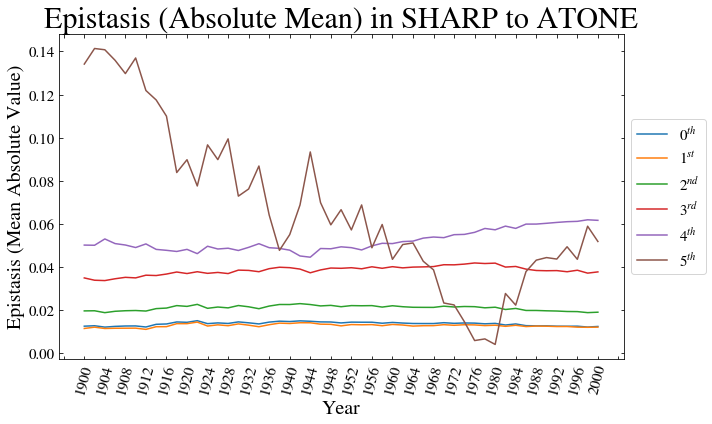

In [57]:
%%time
from scipy.linalg import hadamard
import matplotlib.ticker as ticker


mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'


year = data[0][1:]              # string of the years

order = ['$0^{th}$','$1^{st}$','$2^{nd}$','$3^{rd}$','$4^{th}$','$5^{th}$'][:(WL+1)]  # labels

tick_spacing = 2                # sets how frequently years are displayed on the time axis

H = hadamard(len(bits))         # Hadamard matrix of the appropriate size
         
v = np.array([[0.5,0],[0,-1]])  # this initializes the diagonal matrix V_1
V = v

for i in range(WL-1):
    V = np.kron(V,v)

M = np.matmul(V,H)                 # here we multiply the diagonal matrix V with H
E = []

for j in range(len(W)):
    E.append([])
    for i in range(len(year)):
        E[j].append(np.array(M.dot(W[j][i])))


# definfing the mean absolute epistasis arrays

eabs = []
orders = list(map(len,indices))   # this gives a list of the order (weight) of each bit string

pascal = [[1,3,3,1],[1,4,6,4,1],[1,5,10,10,5,1]][WL-3]


# this constructs the eabs array: a collection of averages of absolute values of elements in E (for each year and word chain)

for k in range(len(W)):
    bins = [[[],[],[],[]],
            [[],[],[],[],[]],
            [[],[],[],[],[],[]]][WL-3]
    eabs.append(bins)

    for each in E[k]:
        s = sum(list(map(abs,each)))            # the line below to turns off normalization
#         s = 1                                   # this shuts off the normalization of the epistasis
        for o in range(len(order)):
            epi_sum = sum(list(map(abs,[each[n] for (n,i) in enumerate(orders) if i==o]))) # sum of the abs(orders)
            eabs[k][o].append(epi_sum/(pascal[o] * s))

            
            
# plotting the mean abs epistasis over time

for j in range(len(W)):
    
    fig,ax = p.subplots(figsize=[10,6])
    
    for i in range(len(order)):
        ax.plot(year,eabs[j][i],label=order[i])

    p.xlabel('Year',fontsize=20)
    p.ylabel('Epistasis (Mean Absolute Value)',fontsize=20)
    p.xticks(rotation=75)
    p.tick_params(labelsize=15,axis='x',direction='in',top=1,right=1)
    p.tick_params(labelsize=15,axis='y',direction='in',top=1,right=1)
    p.title('Epistasis (Absolute Mean) in %s to %s' %(Da_Words[j][0],Da_Words[j][1]),fontsize=30)
    p.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    p.tight_layout()




### Disaggregated Epistasis Graphs

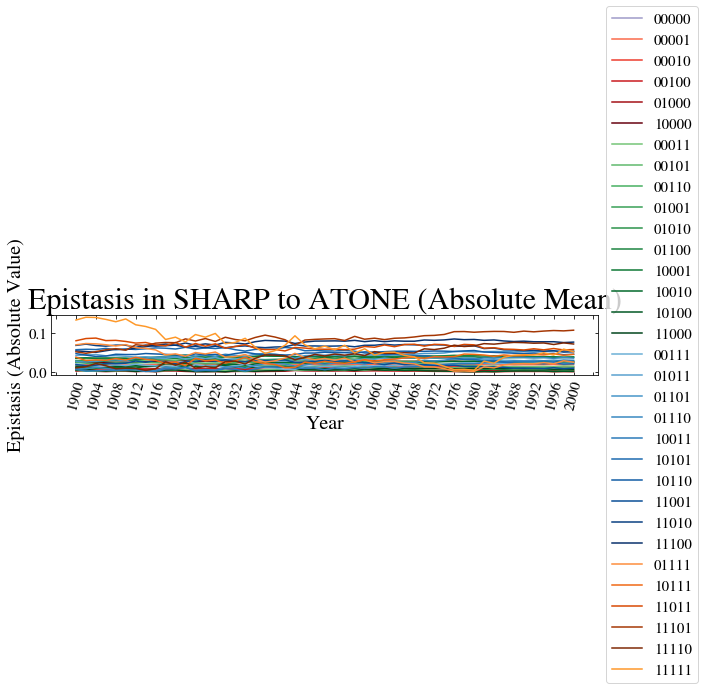

In [58]:
year = data[0][1:]              # string of the years

e_disag = []
for j in range(len(W)):
    e_disag.append([])
    for o in range(len(order)):
        e_disag[j].append([])
        index = [n for (n,i) in enumerate(orders) if i==o]
        for x in range(len(index)):
            e_disag[j][o].append([])
            for each in E[j]:
                s = sum(list(map(abs,each)))   
                e_disag[j][o][x].append(abs(each[index[x]])/s)
                
                
                
order_index = [[n for (n,i) in enumerate(orders) if i==o] for o in range(len(order))]
pascal = [[1,3,3,1],[1,4,6,4,1],[1,5,10,10,5,1]][WL-3]


colors = ['Purples', 'Reds', 'Greens', 'Blues', 'Oranges',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

labels = [[bits[i] for i in order_index[j]] for j in range(WL+1)]


""" Here one can choose a word pair of interest; below we chose CARS to SOME as an example """
word = ['CARS','SOME']
word = Da_Words[0]
word_index = Da_Words.index(word)


fig,ax = p.subplots(figsize=[10,6])

for j in range(len(order)):
    
    cmap = mpl.cm.get_cmap(colors[j])
    color = np.linspace(0.5,1,len(order_index[j]))
    
    for i in range(pascal[j]):
        ax.plot(year,e_disag[word_index][j][i],label=labels[j][i],color=cmap(color[i])[:-1])

p.xlabel('Year',fontsize=20)
p.ylabel('Epistasis (Absolute Value)',fontsize=20)
p.xticks(rotation=75)
p.tick_params(labelsize=15,axis='x',direction='in',top=1,right=1)
p.tick_params(labelsize=15,axis='y',direction='in',top=1,right=1)
p.title('Epistasis in %s to %s (Absolute Mean)' %(word_chain[word_index][0],word_chain[word_index][-1]),fontsize=30)
p.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

p.tight_layout()



### Writing $W[j]$ and $E[j]$ to .csv files

In [59]:
""" Select word-pair of interest; below we use CARS to SOME as an example. Structure save directory in preferred manner """

word = Da_Words[0]
j = Da_Words.index(word)



""" fitness values """

np.savetxt('Fitness/English/%s Letter/fitness %s to %s.csv' %(str(WL),word[0],word[1]),[],delimiter=',')
    
with open('Fitness/English/%s Letter/fitness %s to %s.csv' %(str(WL),word[0],word[1]),'w') as file:
    writer = csv.writer(file,delimiter=',')
    for line in W[j]:
        writer.writerow(line)
        
        

""" epistasis values """
        
np.savetxt('Epistasis/Epistasis Data/English/%s Letters/Epistasis %s to %s.csv' %(str(WL),word[0],word[1]),[],delimiter=',')
    
with open('Epistasis/Epistasis Data/English/%s Letters/Epistasis %s to %s.csv' %(str(WL),word[0],word[1]),'w') as file:
    writer = csv.writer(file,delimiter=',')
    for line in E[j]:
        writer.writerow(line)
        
        
        
""" absolute mean epistasis values """
        
np.savetxt('Epistasis/Absolute Mean Data/English/%s Letters/absolute Epistasis %s to %s.csv' %(str(WL),word[0],word[1]),[],delimiter=',')
    
with open('Epistasis/Absolute Mean Data/English/%s Letters/absolute Epistasis %s to %s.csv' %(str(WL),word[0],word[1]),'w') as file:
    writer = csv.writer(file,delimiter=',')
    for line in np.array(eabs[j]).T:
        writer.writerow(line)      